In [14]:
import time
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.autonotebook import tqdm
import pandas as pd
%matplotlib inline
import torch
%matplotlib inline
from IPython.display import set_matplotlib_formats
import time
from numpy import arange, meshgrid, sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler    

import torch
import torch.nn as nn

import warnings
device = torch.device("cpu")
sns.set()

In [15]:
rng = np.random.default_rng(seed=42)
raw_data = rng.random(20000)
raw_data[0:10000]
X_data = raw_data[0:10000] * 3 - 1.5
Y_data = raw_data[10000:20000] * 2 - 1
Label = (X_data**2 * (np.sin(3*X_data))**2 + Y_data**2 < 0.4).astype(int)

In [16]:
data = pd.DataFrame({'x_coordinate': X_data,
                     'y_coordinate': Y_data,
                     'label': Label})

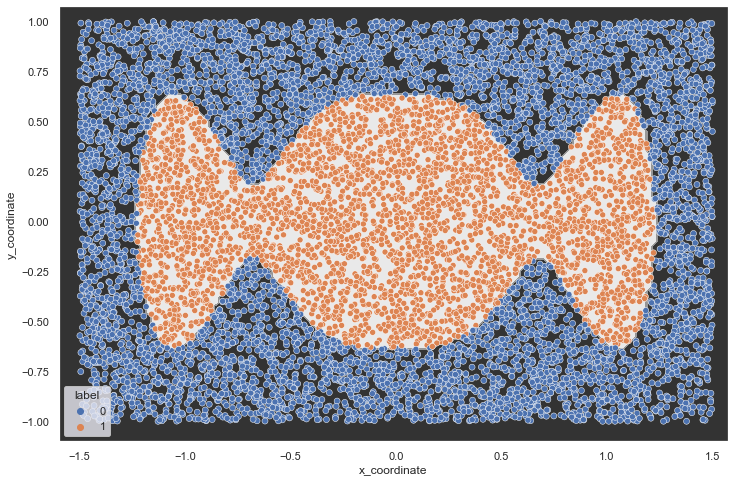

In [17]:
delta = 0.025
x, y = meshgrid(arange(-1.6, +1.6, delta),
                arange(-1.1, +1.1, delta))

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="No contour levels were found within the data range.") 
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.contourf(x, y, x**2 * (np.sin(3*x))**2 + y**2 < 0.4, [0], cmap='Greys_r', levels=2)
    sns.scatterplot(data=data, x="x_coordinate", y="y_coordinate", hue="label")
    plt.show()

In [18]:
Feature = torch.tensor(data[["x_coordinate", "y_coordinate"]].values)
Label_tensor = torch.tensor(data["label"].values)
generator=torch.Generator().manual_seed(52)
dataset = torch.utils.data.TensorDataset(Feature, Label_tensor)
train_ds, test_ds = torch.utils.data.random_split(dataset, [0.7 ,0.3], generator)

In [19]:
features = data[["x_coordinate", "y_coordinate"]]
labels = data["label"]
#X_train, X_test, y_train,  y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

X_train, y_train = train_ds.dataset.tensors
X_test, y_test = test_ds.dataset.tensors

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_input_dim = X_train.shape[1]

#Layer size
n_hidden1 = 300  # Number of hidden nodes
n_hidden2 = 100
n_output =  1   # Number of output nodes = for binary classifier

class BCModel(nn.Module):
    def __init__(self):
        super(BCModel, self).__init__()
        self.layer_1 = nn.Linear(n_input_dim, n_hidden1) 
        self.layer_2 = nn.Linear(n_hidden1, n_hidden2)
        self.layer_out = nn.Linear(n_hidden2, n_output) 
        
        
        self.relu = nn.ReLU()
        self.sigmoid =  nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(n_hidden1)
        self.batchnorm2 = nn.BatchNorm1d(n_hidden2)
        
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.sigmoid(self.layer_out(x))
        
        return x

epochs = 200
input_dim = 2 # Two inputs x1 and x2 
output_dim = 1 # Two possible outputs
learning_rate = 0.1

model = BCModel()

criterion = torch.nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

X_train, X_test = torch.Tensor(X_train),torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train),torch.Tensor(y_test)

losses = []
losses_test = []
Iterations = []
iter = 0
start_time = time.time()

for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(torch.squeeze(outputs), labels.float()) # [200,1] -squeeze-> [200]
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. graph leaves 
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter+=1
    if iter%10==0:
        # calculate Accuracy
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = torch.squeeze(model(X_test))
            loss_test = criterion(outputs_test, y_test.float())
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(torch.squeeze(outputs).round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")
            
print("--- %s seconds ---" % (time.time() - start_time))

Training Epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Iteration: 10. 
Test - Loss: 0.3136523365974426. Accuracy: 87.69
Train -  Loss: 0.3197269141674042. Accuracy: 86.9

Iteration: 20. 
Test - Loss: 0.2824839949607849. Accuracy: 88.48
Train -  Loss: 0.2838538587093353. Accuracy: 88.49

Iteration: 30. 
Test - Loss: 0.2631322741508484. Accuracy: 89.12
Train -  Loss: 0.2616630494594574. Accuracy: 89.1

Iteration: 40. 
Test - Loss: 0.24660654366016388. Accuracy: 89.79
Train -  Loss: 0.25120100378990173. Accuracy: 89.18

Iteration: 50. 
Test - Loss: 0.22324594855308533. Accuracy: 91.04
Train -  Loss: 0.22525766491889954. Accuracy: 90.74

Iteration: 60. 
Test - Loss: 0.22442056238651276. Accuracy: 90.74
Train -  Loss: 0.22069013118743896. Accuracy: 90.62

Iteration: 70. 
Test - Loss: 0.22493962943553925. Accuracy: 90.57
Train -  Loss: 0.2611037492752075. Accuracy: 88.06

Iteration: 80. 
Test - Loss: 0.1884067952632904. Accuracy: 92.56
Train -  Loss: 0.1872805655002594. Accuracy: 92.78

Iteration: 90. 
Test - Loss: 0.2209317684173584. Accuracy: 